# **Gold Price Prediction using Random Forest Regressor**

## **Problem Statement**
The price of gold is closely tied to various financial and economic factors, including stock market performance, commodity prices, and currency exchange rates. In this project, you are tasked with building a machine learning model to predict the price of gold based on historical data from key financial indicators, such as stock indices, commodity prices, and currency exchange rates.

# **Solution**

As written in the problem statement that the price of the gold is closely related to other economic factors such as SPX, USO, SLV, EUR/USD prices. We use past data to relate these to gold prices and train our model then use regression to predict the future gold prices.

**1. Install and import necessary libraries**\
>Pandas, numpy, seaborn and matplotlib for data handling and processing\
>sklearn for models, scaler, metrics, training and hyperparameter tuning

In [ ]:
!pip install pandas numpy

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

**2. Load the Dataset 'gold_price_data.csv'**

In [31]:
# Loading dataset
data = pd.read_csv('gold_price_data.csv')
'''
print(data.head())
print(data.info())
print(data.describe())
'''

'\nprint(data.head())\nprint(data.info())\nprint(data.describe())\n'

**3. Process the data to remove any unwanted or null values and convert the data into the required format for the model**\
>First convert the date and time to usable format and then sort and delete the null/missing values from the dataset.\
>After that we are creating a new column GLD_Lag1 which will store gold price from previous date and another column for storing the\
>average of SPX of past 3 days

In [32]:
''' Pre Processing Data '''

data['Date'] = pd.to_datetime(data['Date']) # Converting dates into Date&time format
data.sort_values('Date', inplace=True)

data = data.dropna()  # Deleting the rows if there are any missing values

data['GLD_Lag1'] = data['GLD'].shift(1) # Adding a new column for previous day gold prices
data['SPX_MA_3'] = data['SPX'].rolling(window=3).mean() # Adding a new column for calculating avg of 3 days SPX
data.dropna(inplace=True)


**4. We are defining features which will be used to relate to gold prices and then split then into training and testing data**\
>For predicting the gold prices we are using the other economic factors as features for our target i.e. gold.\
>Further we are using StandardScalar to improve the performance of our model.\
>Next we're defining our testing and training sets with 80:20 for training:testing with a random_state of 42.

In [33]:
features = ['SPX', 'USO', 'SLV', 'EUR/USD', 'GLD_Lag1', 'SPX_MA_3']
target = 'GLD'
X = data[features]
y = data[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # Scaling the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)  # Defining training and testing sets

**5. Now lets compare the various models on the data we just gathered by comparing the Mean errors and chose the one which satisfies our requirements**

In [34]:
''' Defining different models to compare their performance '''

models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=300, random_state=42),
    'Support Vector Regressor': SVR()
}

results = {}

for model_name, model in models.items():

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results[model_name] = {'MAE': mae, 'RMSE': rmse}

results_df = pd.DataFrame(results).T
print(results_df)

                               MAE      RMSE
Linear Regression         1.053145  1.477296
Decision Tree             1.362817  1.860299
Random Forest             1.003096  1.379182
Support Vector Regressor  1.458926  2.398595


**6. As we saw above the Random Forest model has the least error margin out of all the models, hence we will go with Random Forest regressor for our model which uses decision trees to relate and calculate the required data. Here, we are training our model on 300 decision trees with a random_state of 42**

In [35]:
''' Using Random Forest Regression to train the model '''

rf_model = RandomForestRegressor(n_estimators=300, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=300, random_state=42)

# **NOTE:**
Even though Random Forest got the least error, that's not the only reason to chose it.
Some other important features to chose Random Forest are:


*   **Ability to Handle Non-Linear Relationships:** As we know our dataset consists of non-linear relations, random forest can easily help with that.
*   **Multiple Decision Trees:** Random forest model can be trained on multiple decision trees which makes it even more accurate.

*   **Scalability:** Ability to handle large datasets with scalability is better than other regression models
*   **Overfitting and Robustness:** Decision trees can overfit, this is mitigated by averaging the results and reducing the variance. Along with it the Random forest is more robust as each decision tree is trained on random datas from the dataset.





**7. To evaluate our model again we will be defining another function just to evaluate our model**

In [36]:
''' defining function to evaluate the model '''

def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    return mae, rmse

In [37]:
''' Printing Mean Absolute Error and Root Mean Squared Error after evaluation'''

rf_mae, rf_rmse = evaluate_model(rf_model, X_test, y_test)
print(f"Random Forest => MAE: {rf_mae}, RMSE: {rf_rmse}")


Random Forest => MAE: 1.0030963084133984, RMSE: 1.3791822815397747


**8. Hyper-parameter tuning using Grid search**\
>In order to find the best possible parameters on which our model will have the least error margin, which is eassesntial to improve the model's perfomance.
For now we only have few parameters but we can increase the parameters even more in order to reduce the error margin even further but it also increases the computational time. Hence, the smaller the parameters the faster is execution

In [38]:
''' Hyperparameter tuning for Random Forest Regression '''

param_grid = {
    # Defining different combination values for parameters
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

# Defining Grid search to search for best combination from param_grid
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_
best_mae, best_rmse = evaluate_model(best_rf_model, X_test, y_test)
print(f"Tuned Random Forest - MAE: {best_mae}, RMSE: {best_rmse}")


Tuned Random Forest - MAE: 1.0030963084133984, RMSE: 1.3791822815397747


In [26]:
''' Hyperparameter tuning for Random Forest Regression
    Uncomment this if you have a better PC as it will require more computation power and time to execute
'''

'''
param_grid = {
    # Defining different combination values for parameters
    'n_estimators': [100, 300, 500, 700],
    'max_depth': [10, 30, 50, None],
    'min_samples_split': [2, 5, 7, 10]
}

# Defining Grid search to search for best combination from param_grid
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_
best_mae, best_rmse = evaluate_model(best_rf_model, X_test, y_test)
print(f"Tuned Random Forest - MAE: {best_mae}, RMSE: {best_rmse}")
'''

Tuned Random Forest - MAE: 0.9988749809108172, RMSE: 1.3775374582860525


**9. Now that we have our model trained, we can predict the past gold prices and visualize the data using graphs in order to see the accuracy of our model in a better way.**\
>The following graph shows the comparison between the actual value of gold(blue) to the predicted value(red)

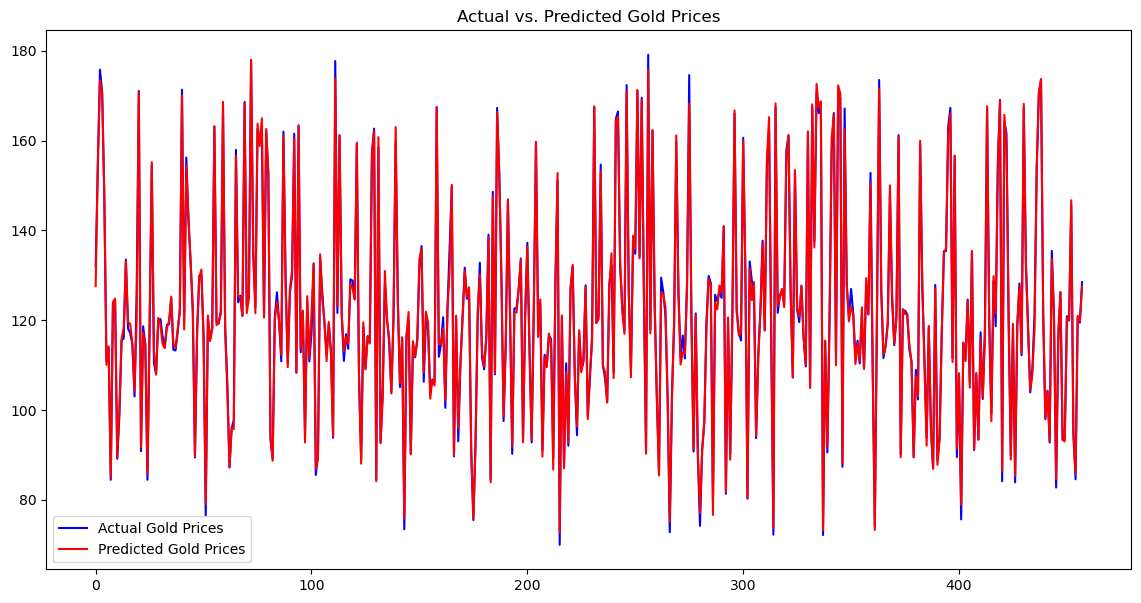

In [39]:
''' Visualizing the actual and predicted gold prices '''

y_pred = rf_model.predict(X_test)
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Actual Gold Prices', color='blue')
plt.plot(y_pred, label='Predicted Gold Prices', color='red')
plt.title('Actual vs. Predicted Gold Prices')
plt.legend()
plt.show()


**10. Now that we can see our model can predict past gold prices with somewhat accuracy we can use the below program in orde to predict the price of gold on any date based on the input data**
>Note: In the below program you have to enter all the data manually including gold lag and average spx value

In [40]:
''' Predicting the gold price for any day based on values of other parameters '''

def predict_day_price():

  spx = float(input("Enter SPX value: "))
  uso = float(input("Enter USO value: "))
  slv = float(input("Enter SLV value: "))
  eur_usd = float(input("Enter EUR/USD value: "))
  gld_lag1 = float(input("Enter previous day's GLD value: "))
  spx_ma_3 = float(input("Enter 3-day average SPX value: "))

  new_data = pd.DataFrame({
      'SPX': [spx],
      'USO': [uso],
      'SLV': [slv],
      'EUR/USD': [eur_usd],
      'GLD_Lag1': [gld_lag1],
      'SPX_MA_3': [spx_ma_3]
  })

  new_data_scaled = scaler.transform(new_data)

  predicted_price = rf_model.predict(new_data_scaled)[0]

  print(f"Predicted Gold Price for the day: {predicted_price:.2f}")

predict_day_price()

Enter SPX value:  238.5
Enter USO value:  384.2
Enter SLV value:  483.67
Enter EUR/USD value:  1.24
Enter previous day's GLD value:  392
Enter 3-day average SPX value:  483.6


Predicted Gold Price for the day: 181.09


**11. Optionally if you want to see which of the following feature was the most important in predicting the gold price in our model we can use the code below to see.**
>As we can see from the following chart the previous day gold value is the most important feature, followed by SLV, USO, EUR/USD and SPX.

SPX: 0.0004
USO: 0.0006
SLV: 0.0027
EUR/USD: 0.0005
GLD_Lag1: 0.9954
SPX_MA_3: 0.0004


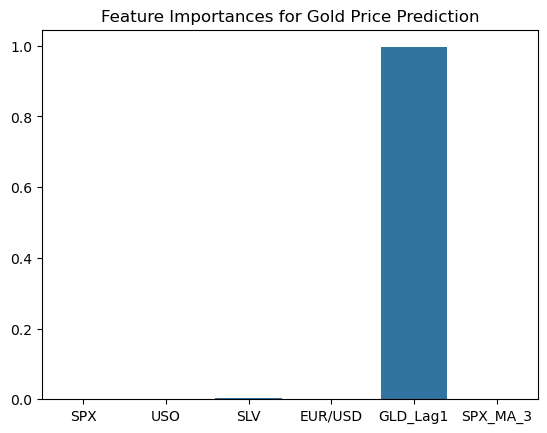

In [29]:
''' Visualizing the important features for predicting the gold price '''

feature_importances = rf_model.feature_importances_
for feature, importance in zip(features, feature_importances):
    print(f"{feature}: {importance:.4f}")

sns.barplot(x=features, y=feature_importances)
plt.title("Feature Importances for Gold Price Prediction")
plt.show()
